In [5]:
import pandas as pd
df = pd.read_csv('exoTest.csv')
print(df.shape)
print(df.head())

(570, 3198)
   LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6   FLUX.7  \
0      2   119.88   100.21    86.46    48.68    46.12    39.39    18.57   
1      2  5736.59  5699.98  5717.16  5692.73  5663.83  5631.16  5626.39   
2      2   844.48   817.49   770.07   675.01   605.52   499.45   440.77   
3      2  -826.00  -827.31  -846.12  -836.03  -745.50  -784.69  -791.22   
4      2   -39.57   -15.88    -9.16    -6.37   -16.13   -24.05    -0.90   

    FLUX.8   FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0     6.98     6.63  ...      14.52      19.29      14.44      -1.62   
1  5569.47  5550.44  ...    -581.91    -984.09   -1230.89   -1600.45   
2   362.95   207.27  ...      17.82     -51.66     -48.29     -59.99   
3  -746.50  -709.53  ...     122.34      93.03      93.03      68.81   
4   -45.20    -5.04  ...     -37.87     -61.85     -27.15     -21.18   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      13.33      45.50      31.93

In [2]:
import numpy as np

# Rename for easier reference
df.rename(columns={'LABEL': 'label'}, inplace=True)

# Extract features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Convert label 2 → 0
y = np.where(y == 2, 0, 1)

# Confirm the transformation
print(np.unique(y, return_counts=True))  # Should show counts of 0 and 1

(array([0, 1]), array([  5, 565]))


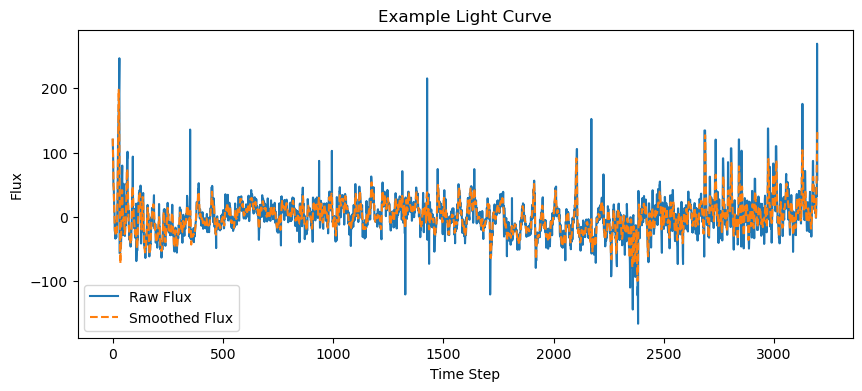

In [3]:
from scipy.signal import savgol_filter

# Apply smoothing to one sample for now
sample_flux = X[0]
smoothed_flux = savgol_filter(sample_flux, window_length=11, polyorder=3)

# Plot the result
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(sample_flux, label='Raw Flux')
plt.plot(smoothed_flux, label='Smoothed Flux', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Flux')
plt.title('Example Light Curve')
plt.legend()
plt.show()

In [4]:
# Normalize each light curve row (sample-wise)
X_norm = (X - X.min(axis=1, keepdims=True)) / (X.max(axis=1, keepdims=True) - X.min(axis=1, keepdims=True))

# Check shape
print(X_norm.shape)  # Should match original

(570, 3197)


In [4]:
import numpy as np

X = np.load('X_clean.npy')
y = np.load('y_clean.npy')

In [5]:
##Prepare data for PyTorch 

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Split data into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, 3197)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [6]:
## Define CNN Model 

import torch.nn as nn
import torch.nn.functional as F

class ExoCNN(nn.Module):
    def __init__(self):
        super(ExoCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(32 * 796, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (N, 16, ~1596)
        x = self.pool(F.relu(self.conv2(x)))  # (N, 32, ~796)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))     # Sigmoid for binary output

In [10]:
##Train the Model 

model = ExoCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # Increase to ~20 for better accuracy
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

Epoch 1 Loss: 0.3120
Epoch 2 Loss: 0.4477
Epoch 3 Loss: 0.2696
Epoch 4 Loss: 0.0531
Epoch 5 Loss: 0.0450


In [15]:
#Eval Accuracy on test 

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 99.12%


Test Accuracy: 0.9912
Precision: 0.9912
Recall: 1.0000
F1-score: 0.9956


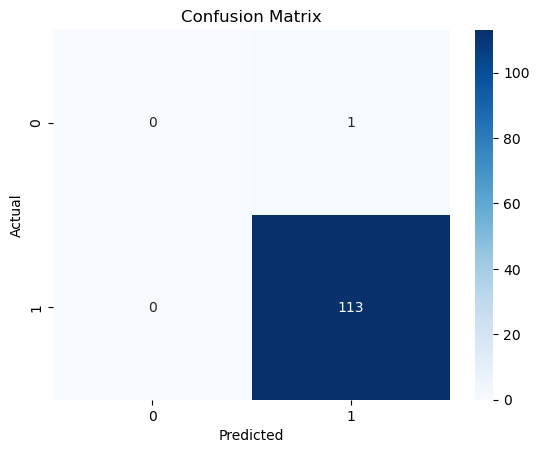

In [13]:
## Task 4: Evaluating and Testing 
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make sure your model is in evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Predict on test data
    y_pred_probs = model(X_test_tensor).squeeze()  # output probabilities
    y_pred = (y_pred_probs >= 0.5).int().numpy()   # threshold at 0.5 to get labels

y_true = y_test_tensor.int().numpy()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()